# **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note** If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import collections

%matplotlib inline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [2]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = ((y2-y1)/(x2-x1))
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            
def get_segments(img, lines, color=[255, 0, 0], thickness=2):
    """ 
    Separate line segments between left and right based on their slope
    ((y2-y1)/(x2-x1)). Slope > 0.5 => right and Slope < -0.5 => left.

    Returns extra information about the segments such as: slope, intersect and weight
    (weight is the length of the segment: (x2-x1)**2 + (y2-y1)**2) 
    and is used in the extrapolate function)
    
    In debug mode, this function draws the individual segments with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    """
    
    slope_left, slope_right, intersect_left, intersect_right, weights_left, weights_right = [],[],[],[],[],[]
    lines_info = np.empty([len(lines), 1, 4], dtype=float)
    left_lines = []
    right_lines = []

    for i,line in enumerate(lines):
        for x1,y1,x2,y2 in line:
            slope = (1.0*(y2-y1)/(x2-x1))
            intersect = y1 - x1 * slope
            weights = np.sqrt(((x2-x1)**2 + (y2-y1)**2))
            min_y = min(y1,y2)
            lines_info[i] = [[slope, intersect, weights, min_y]]
            if slope > 0.5:
                right_lines.append(i)
                if _debug_:
                    cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            elif slope < -0.5:
                left_lines.append(i)
                if _debug_:
                    cv2.line(img, (x1, y1), (x2, y2), [0,255,0], thickness)

    #print('lines info shape:', lines_info.shape)
    #print('lines info shape LEFT:', lines_info[left_lines].shape)
    #print('lines info shape RIGHT:', lines_info[right_lines].shape)
    
    # time to return lines_info / left_lines / right_lines
    
    #print(lines_info[left_lines].shape) #8, 1, 3
    #print(lines_info[left_lines][0].shape) # 1, 3
    #print(lines_info[left_lines][0][0].shape) #3
    #print(lines_info[left_lines][0][0][0].shape) #()
    #print(lines_info[left_lines][0][0][0]) #()
    
    return lines_info, left_lines, right_lines
    
def extrapolate(img, lines_info, left_lines, right_lines, ytop, color=[255, 0, 0], thickness=10):
    """ 
    Extrapolates the input segments (segments are represented by their slope, intersect and weight (length)) 
    into a single line.
    
    Extrapolation Methodology: 
    1. identify and exclude outliers based on both slope and intersect
    2. average the slopes and intersects of the remaining lines

    This function adds the newly extrapolated lines to 
    global variable _lines_memory_ that keeps track of the last _N_ (20) extrapolated lines.
    
    Calls draw_smoothed_line to plot: 
    The average of the last _N_ (20) extrapolated lines is drawn on the image inplace 
    (mutates the image) with `color` and `thickness`.
    This helps make the lines more stable in the videos.
    
    """ 
    
    global _lines_memory_
    
    for side in ['left','right']:
    
        if side == 'left':
            segments = lines_info[left_lines]
            lines_memory_side = _lines_memory_[0]
        elif side == 'right':
            segments = lines_info[right_lines]
            lines_memory_side = _lines_memory_[1]
        else:
            raise Exception('wrong side argument in extrapolate function. Values can only be left and right. Value provided:',side)
    
        outliers = get_outliers(segments[:,0,0], segments[:,0,1])
        lines_no_outliers = segments[outliers]
        weights = lines_no_outliers[:,0,2]
        slopes = lines_no_outliers[:,0,0]
        intersects = lines_no_outliers[:,0,1]
        ys = lines_no_outliers[:,0,3]

        if (np.sum(weights) > 0):
            avg_slope = np.average(slopes, axis = 0, weights = weights)
            avg_intersect = np.average(intersects, axis = 0, weights = weights)
            min_y = np.min(ys, axis = 0)
            lines_memory_side.append([avg_slope,avg_intersect,min_y])
        
    draw_smoothed_line(img, _lines_memory_, 'left', ytop = ytop, color = color, thickness = thickness)
    draw_smoothed_line(img, _lines_memory_, 'right', ytop = ytop, color = color, thickness = thickness)
    
def draw_smoothed_line(img, lines_memory_side, side, ytop, color, thickness):
    """ 
    The average of the last _N_ (20) extrapolated lines is drawn on the image inplace 
    (mutates the image) with `color` and `thickness`.
    The minimum y value is determined as the minimum of the minimum of y for the left and the right lines and a fixed value
    That's to make sure that both the left and right line start at the same ymin
    If the y value is set to a constant, the lines are either not long enough in straight lines or too long 
    (and therefore going too much on the road when turning)
    
    This helps make the lines more stable in the videos.
    """ 
    
    if side == 'left':
        lines_memory_side = _lines_memory_[0]
        lines_memory_side_other = _lines_memory_[1]
    elif side == 'right':
        lines_memory_side = _lines_memory_[1]
        lines_memory_side_other = _lines_memory_[0]
    else:
        raise Exception('wrong side argument in extrapolate function. Values can only be left and right. Value provided:',side)
    
    smoothed_line = np.sum(lines_memory_side, axis = 0)/len(lines_memory_side)
    smoothed_line_other = np.sum(lines_memory_side_other, axis = 0)/len(lines_memory_side_other)
    smoothed_slope = smoothed_line[0]
    smoothed_intersect = smoothed_line[1]
    smoothed_min_y = smoothed_line[2]     
    smoothed_min_y_other = smoothed_line_other[2]    
    
    draw_y_top = int(min(smoothed_min_y, smoothed_min_y_other, ytop + 20))
    
    y_1 = draw_y_top
    x_1 = int((y_1 - smoothed_intersect)/smoothed_slope)

    y_2 = img.shape[0]
    x_2 = int((y_2 - smoothed_intersect)/smoothed_slope)

    cv2.line(img, (x_1, y_1), (x_2, y_2), color, thickness)

def get_outliers(data1, data2, m=2):
    return (abs(data1 - np.mean(data1)) < m * np.std(data1)) & (abs(data2 - np.mean(data2)) < m * np.std(data2))
    
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap, ytop):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((*img.shape, 3), dtype=np.uint8)

    lines_info, left_lines, right_lines = get_segments(line_img, lines)
    
    extrapolate(line_img, lines_info, left_lines, right_lines, ytop)
    
    return line_img

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def yellow_to_white(image):
    """
    identify the yellow parts of the image and replace them with white
    """
    #yellow = np.uint8([[[255,255,0 ]]])
    #hsv_yellow = cv2.cvtColor(yellow,cv2.COLOR_BGR2HSV)
    
    frame = np.copy(image)
    hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
    # define range of yellow color in HSV
    upper_yellow = np.array([100, 255, 255]) 
    lower_yellow = np.array([80, 100, 100]) 

    # Threshold the HSV image to get only yellow colors
    mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
    
    mask3 = np.dstack((mask, mask, mask)) 
    max_image = cv2.max(frame, mask3)

    return max_image


## Pipeline

In [3]:
# Global variables:
_N_ = 20 # smooth lines over the last N frames
_lines_memory_ = [collections.deque(maxlen=_N_),collections.deque(maxlen=_N_)]
_debug_ = False # in debug mode, we plot the region of interest and the different segments as well

In [4]:
def reset_lines_memory():

    global _lines_memory_
    
    _lines_memory_[0].clear()
    _lines_memory_[1].clear()

def identify_lanes(image):

    # 0. Convert yellow to white (to make challenge video work, otherwise there was not enough contrast on some frames.)
    image_yellow_to_white = yellow_to_white(image)
    
    # 1. convert to gray scale
    image_gray = grayscale(image_yellow_to_white)

    # 2. Apply gaussian blur
    kernel_size = 5
    image_gray_blurred = gaussian_blur(image_gray, kernel_size)

    # 3. Identify edges using canny function
    low_threshold = 50 
    high_threshold = 250
    edges = canny(image_gray_blurred, low_threshold, high_threshold)

    # 4. Identify region of interest
    imshape = edges.shape
    ytop = int(6*imshape[0]/10)
    xleft = int(imshape[1]/2-imshape[1]/20)
    xright = int(imshape[1]/2+imshape[1]/20)
    vertices = np.array([[(0,imshape[0]),(xleft, ytop), (xright, ytop), (imshape[1],imshape[0])]], dtype=np.int32)

    masked_image = region_of_interest(edges, vertices)

    # 5. Identify segments within the region of interest using Hough lines
    line_img = hough_lines(img = masked_image, rho = 2, theta =  np.pi/180, 
                           threshold = 15, min_line_len = 20, max_line_gap = 5, 
                           ytop=ytop
                          )
    if(_debug_):
        # Plot the region of interest to see where it is (optional - just to adjust the vertices)
        v = [[list(vertices[0,i]) + list(vertices[0,j])] for i in range(3) for j in range(4) if j == i+1]
        draw_lines(line_img, v, color=[0,0,255], thickness = 2)

    # 6. Draw the lines on the edge image
    lines_edges = cv2.addWeighted(image, 0.8, line_img, 1, 0) 

    return lines_edges


## Test on Images

Now you should build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [5]:
import os
os.listdir("test_images/")

['optional_image.jpg',
 'optional_image_2.jpg',
 'solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

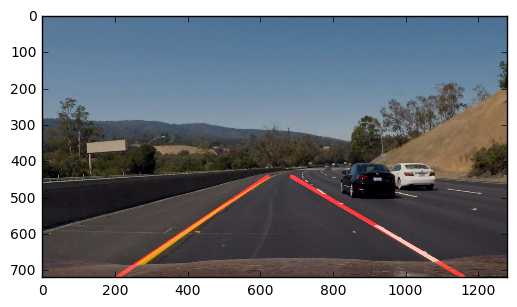

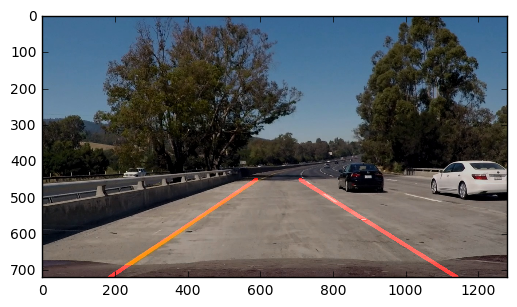

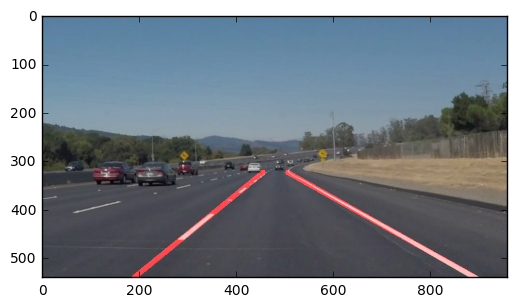

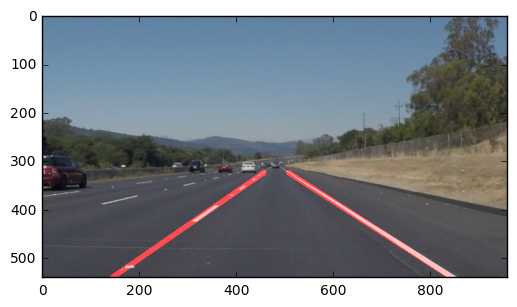

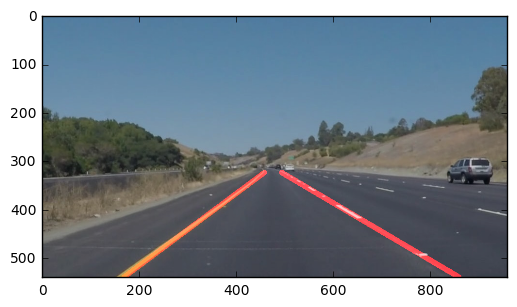

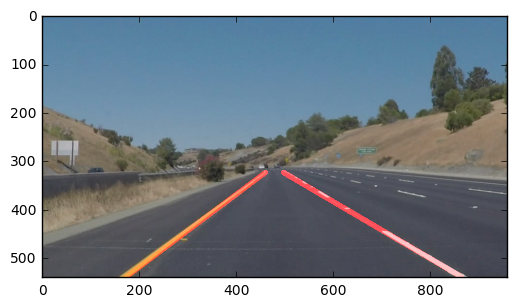

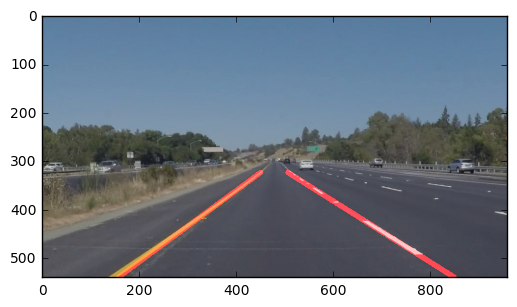

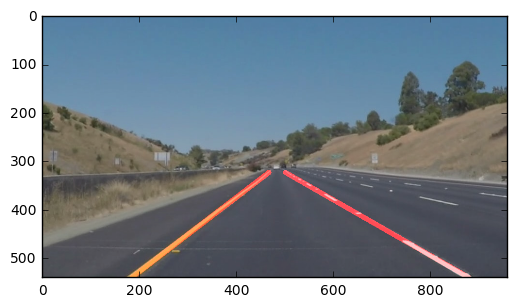

In [6]:
repo = "test_images/"
for image_locations in os.listdir("test_images/"):
    reset_lines_memory()
    image = mpimg.imread(repo+image_locations)
    lines_edges_1 = identify_lanes(image)
    plt.imshow(lines_edges_1)
    plt.show()
    

run your solution on all test_images and make copies into the test_images directory).

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

In [7]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [8]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image with lines are drawn on lanes)
    result = identify_lanes(image)
    return result

Let's try the one with the solid white lane on the right first ...

In [9]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
reset_lines_memory()
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|█████████▉| 221/222 [00:03<00:00, 71.27it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

CPU times: user 3.73 s, sys: 957 ms, total: 4.68 s
Wall time: 3.51 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

**At this point, if you were successful you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform.  Modify your draw_lines function accordingly and try re-running your pipeline.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [11]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
reset_lines_memory()
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|█████████▉| 681/682 [00:11<00:00, 61.16it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

CPU times: user 13.4 s, sys: 3.53 s, total: 16.9 s
Wall time: 11.7 s


In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Reflections

Congratulations on finding the lane lines!  As the final step in this project, we would like you to share your thoughts on your lane finding pipeline... specifically, how could you imagine making your algorithm better / more robust?  Where will your current algorithm be likely to fail?

Please add your thoughts below,  and if you're up for making your pipeline more robust, be sure to scroll down and check out the optional challenge video below!


### General limitations of the current implementation: 
- This implementation assumes that the car is already located between the lanes 
(because of the region of interest)
- It also assumes that the car is moving in the direction of the lanes. Otherwise, selecting the left/right lines based on their slopes would not work.
- It will fail at an intersection or if there are no lines at all.
- It will also have a hard time if the lanes don't have a hard contrast with the rest of the road.

### How to make the implementation more robust:
To make the implementation more robust and work on the optional challenge, I've already done the following:
- I used percentages of the image size to define the region of interest (to handle the optional challenge video that has a different size).
- I removed outlier segments before extrapolating them into a single line.
- I converted yellow lines to white to increase contrast. This was necessary for the challenge video.
- I averaged the lines of the last 20 frames. This made the lines a lot more stable.
- I made the minimum y coordinate of the lines variable so that the lanes are longer in straight lines and shorter when it turns (since it's hard to represent a turn with a long straight line!)

I've also tried a different extrapolation methodology (add all the points in the segments and fit a linear least squares). However, my original implementation of doing a weighted average of the intersects and slopes turned out to perform better (weights based on length of segment).

Some extra improvements could be made such as identifying the most reliable line (left or right) and deriving the other line from it, or use a completely different approach to detect lines.

## Submission

If you're satisfied with your video outputs it's time to submit!  Submit this ipython notebook for review.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [13]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
#im1 = clip2.get_frame(t=5)
#mpimg.imsave('optional_image_2.jpg',im1)
reset_lines_memory()
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|██████████| 251/251 [00:08<00:00, 30.88it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

CPU times: user 9.09 s, sys: 2.29 s, total: 11.4 s
Wall time: 9.06 s


In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))